In [ ]:
import os
import sys
from pathlib import Path
import warnings
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import yaml
import importlib
import numpy as np
import gvar as gv
import platform
import pprint
cwd = Path(os.getcwd())
# Assuming your notebook is in the project root, set the project root as cwd
project_root = cwd.parent
print(project_root)
# If your notebook is in a subdirectory of the project root, you can modify the path accordingly:
# project_root = cwd.parent  # Go up one directory level
# project_root = cwd.parent.parent  # Go up two directory levels
# Add the project root directory to sys.path
sys.path.insert(0, str(project_root))
# sys.path.append('../')

# local imports 
import xpt.fit_analysis as xfa
import xpt.priors as priors
import xpt.i_o as i_o
import xpt.fit_routine as fit
import xpt.plots as plots
warnings.simplefilter(action="default")
warnings.filterwarnings('ignore')

# Define paths and other variables
if platform.system() == 'Darwin':
    base_dir = '/Users/grantdb/lqcd'
else:
    base_dir = '/home/gmoney/lqcd'

data_dir = os.path.join(base_dir, "data")
hyperon_data_file = os.path.join(data_dir,"hyperon_data.h5")


/Users/grantdb/lqcd/hyperon-xpt-master


In [ ]:
from importlib import reload
reload(xfa)
reload(i_o)
reload(fit)
reload(priors)

<module 'xpt.priors' from '/Users/grantdb/lqcd/hyperon-xpt-master/xpt/priors.py'>

In [3]:
# gv.load('../scale_setting.p')
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
xi_models = models['models']['xi_system']
lam_sigma_models = models['models']['lam_sigma_system']

### perform hbxpt mass extrapolations using physical mass of hyperons in mev with scale setting parameterization ###

In [4]:

prior = priors.get_prior(units='mev')
prior_fpi = priors.get_prior(units='lam_chi')
input_output = i_o.InputOutput(project_path=data_dir)
data, ensembles = input_output.get_data(units='phys')
data_units_fpi,ensembles = input_output.get_data(units='fpi')
new_prior = input_output.make_prior(data=data,prior=prior)
new_prior_fpi = input_output.make_prior(data=data_units_fpi,prior=prior_fpi)
phys_point_data = input_output.get_data_phys_point()

In [7]:

reload(fit)

# print(base.prep_data(data=data))
model_info=xi_models['xi:xi_st:d_n2lo:l_n2lo:x_n2lo:phys']
xi_fit = fit.FitRoutine(prior=prior,data=data, project_path=data_dir,model_info=model_info,
                    phys_point_data=phys_point_data, emp_bayes=None,empbayes_grouping=None)
print(xi_fit)
print(xi_fit.extrapolation(observables=['sigma_pi','mass'],data=phys_point_data))
# fpi units # 
xi_fit_fpi = fit.FitRoutine(prior=prior_fpi,data=data_units_fpi, project_path=data_dir,model_info=model_info,
                    phys_point_data=phys_point_data, emp_bayes=None,empbayes_grouping=None)
print(xi_fit_fpi)
print(xi_fit_fpi.extrapolation(observables=['sigma_pi','mass'],data=phys_point_data))
model_info_lam = lam_sigma_models['lam:sigma:sigma_st:l_n2lo:d_n2lo:x_n2lo:phys']
lam_fit = fit.FitRoutine(prior=prior,data=data, project_path=data_dir,model_info=model_info_lam,
                    phys_point_data=phys_point_data, emp_bayes=None,empbayes_grouping=None)

print(lam_fit)
print(lam_fit.extrapolation(observables=['sigma_pi','mass'],data=phys_point_data))

extrap_analysis = xfa.Xpt_Fit_Analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=model_info, prior=new_prior,project_path=data_dir)
'''model average with lsqfitics'''
# y_fit_ = extrap_analysis.extrapolation()
# print(y_fit_)

# extrap_analysis.plot_params(xparam='mpi_sq',yparam='xi')
# extrap_analysis.plot_params(xparam='eps2_a',observable='xi',show_plot=True,eps=False)

# extrap_analysis.plot_params_fit(param='a',observable='xi',eps=False)
# extrap_analysis.plot_params_fit(param='mpi_sq',observable='xi')




Least Square Fit:
  chi2/dof [dof] = 0.3 [34]    Q = 1    logGBF = -154.81

Parameters:
       m_{xi,0}       1314 (32)      [    1000 (400) ]  
         s_{xi}       1.35 (99)      [     0.0 (2.0) ]  
       b_{xi,4}     0.07 (1.93)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.58 (28)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.4 (1.1)      [     2.0 (4.0) ]  
      d_{xi,al}      -1.7 (3.1)      [     0.0 (5.0) ]  
       d_{xi,s}      -0.12 (63)      [     0.0 (5.0) ]  
      d_{xi,as}       2.2 (3.0)      [     0.0 (5.0) ]  
      d_{xi,ls}      -0.2 (4.4)      [     0.0 (5.0) ]  
      d_{xi,ss}      -1.0 (3.7)      [     0.0 (5.0) ]  
      g_{xi,xi}     0.01 (3.98)      [     0.3 (4.0) ]  
   g_{xi_st,xi}       0.2 (2.4)      [     0.7 (3.0) ]  
    m_{xi_st,0}       1549 (40)      [    1300 (400) ]  
       a_{xi,4}      -0.5 (1.9)      [     0.0 (2.0) ]  
     s_{xi,bar}       0.4 (1.2)      [     0.0 (2.0) ]  
    b_{xi_st,4}       0.9 (4.5)      [     0.0 (5.0) ]  


'model average with lsqfitics'

In [ ]:
reload(i_o)
xi_out = xi_fit.fit
m_pi = phys_point_data['m_pi']
lam_chi = phys_point_data['lam_chi']
m_proton = xi_out.p['m_{xi,0}']
e_pi = m_pi / lam_chi
# sigma = m_pi**2 *gv.deriv(m_proton, e_pi**2)
# print(sigma)
l3 = gv.gvar('3.53(26)')
l4 = gv.gvar('4.73(10)')
term_0 = lam_chi * e_pi/2 * m_proton
term_1 = lam_chi * e_pi/2 * m_proton * e_pi**2*(5/2 - l3/2 - 2*l4 )
term_2 = e_pi**2 * m_proton*(l4-1)
sigma = term_0 + term_1 + term_2
print(term_0,term_1,term_2,sigma)
# sigma_analytic = (e_pi/2 * (1 + e_pi**2*(5/2 - l3/2 - 2*l4 )) *m_proton_deriv) * lam_chi
print('sigma w/ gv.deriv:',sigma)
print('sigma analytic:',sigma_analytic)


88556(2143) -10488(410) 66.5(2.6) 78134(1913)
sigma w/ gv.deriv: 78134(1913)


NameError: name 'sigma_analytic' is not defined

In [ ]:
extrap_analysis.plot_params_fit(param='a',observable='xi_st')


NameError: name 'extrap_analysis' is not defined

Error encountered for Model: xi:xi_st:d_n2lo:l_lo
Error details: 'units'
Error encountered for Model: xi:xi_st:d_n2lo:l_n2lo
Error details: 'units'


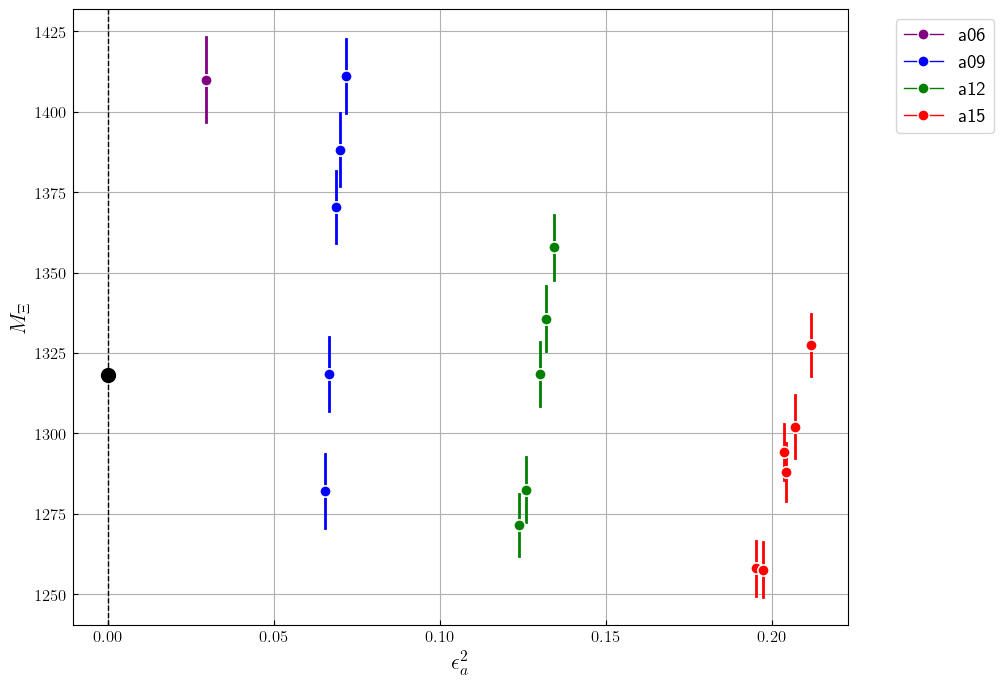

Model: xi:xi_st:d_n2lo:l_n2lo:x_n2lo


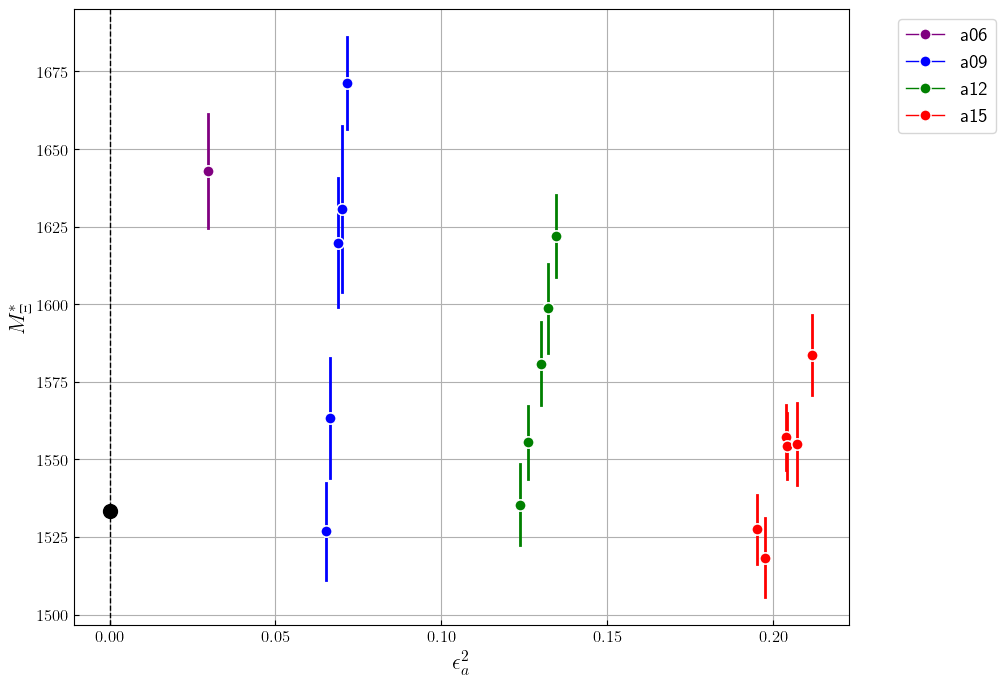

Model: xi:xi_st:d_n2lo:l_n2lo:x_n2lo


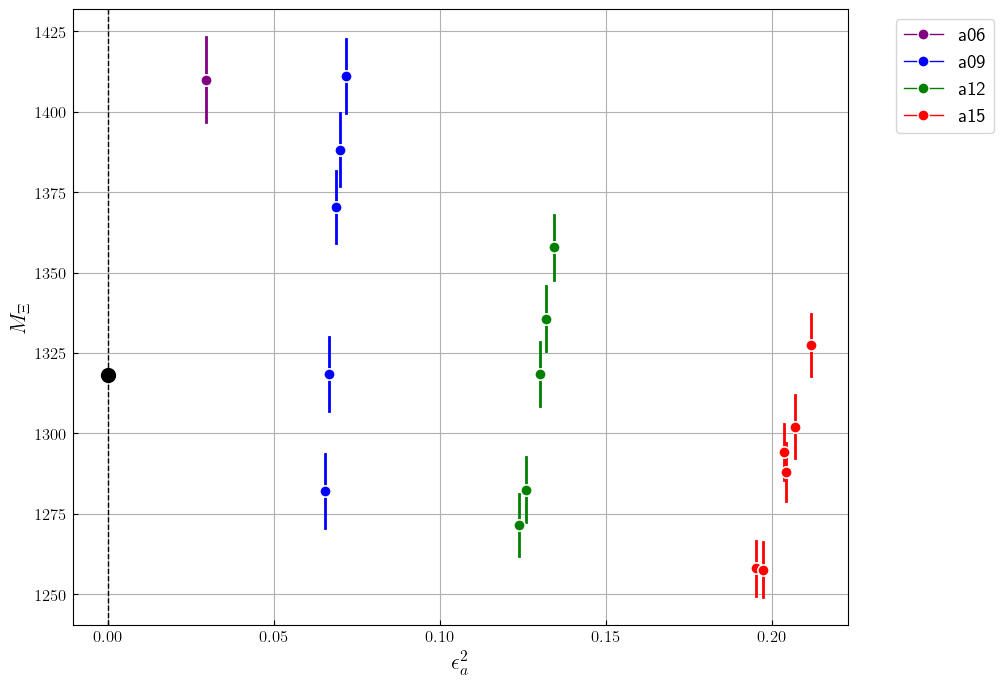

Model: xi:xi_st:d_n2lo:l_n2lo:x_n2lo:phys


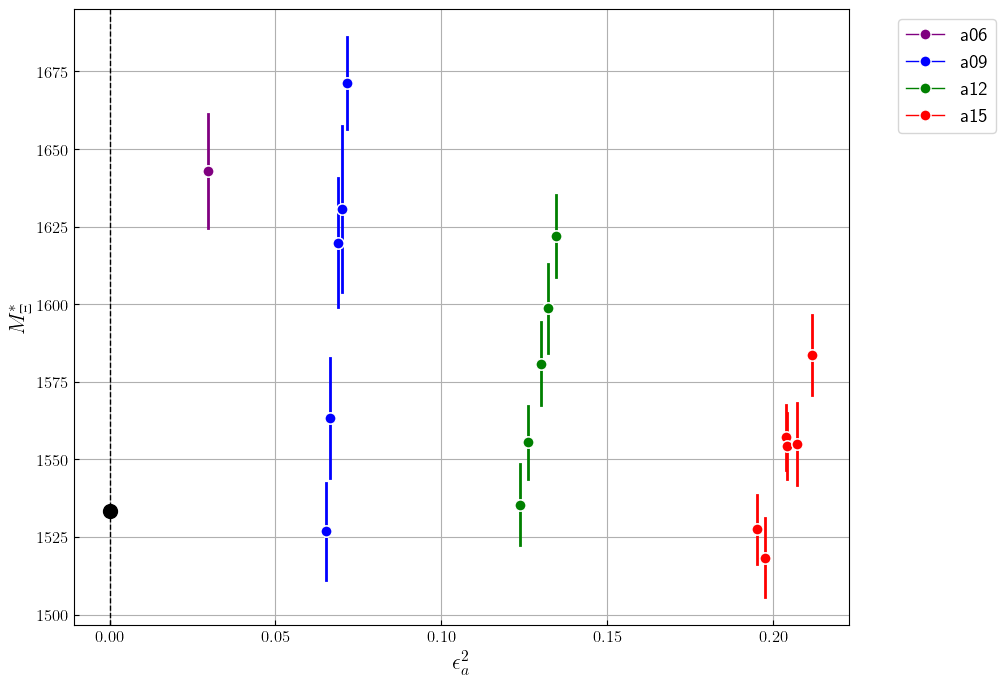

Model: xi:xi_st:d_n2lo:l_n2lo:x_n2lo:phys
Error encountered for Model: xi:xi_st:d_n2lo:l_nlo:x_n2lo
Error details: 'units'
Error encountered for Model: xi:xi_st:d_n2lo:l_lo:s_lo
Error details: 'units'
Error encountered for Model: xi:xi_st:d_n2lo:l_nlo:s_lo:x_n2lo
Error details: 'units'
Error encountered for Model: xi:xi_st:d_n2lo:l_n2lo:s_lo:x_n2lo
Error details: 'units'


In [ ]:

importlib.reload(xfa)
importlib.reload(fit)
importlib.reload(i_o)

def perform_fit_and_plot(model_type,mdl_key):
    mdl_info = model_type[mdl_key]
    extrap_analysis = xfa.Xpt_Fit_Analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=mdl_info, prior=new_prior,project_path=data_dir)
    fit_out = extrap_analysis.fit
    for part in mdl_info['particles']:
        extrap_analysis.plot_params(observable=part,xparam='eps2_a',show_plot=True)
        print(f"Model: {mdl_key}")
        # print(fit_out)

    # print(extrap_analysis)

        # return fit_out

with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
xi_models = models['models']['xi_system']
for mdl_key in xi_models:
    # mdl_info = xi_models[mdl_key]
    try:
        perform_fit_and_plot(xi_models,mdl_key)
    except Exception as e:
        print(f"Error encountered for Model: {mdl_key}")
        print(f"Error details: {e}")
        continue
    


## Xi, Xi* system SU(2) HBXPT extrapolation ##


In [ ]:
from scipy.interpolate import interp1d
importlib.reload(xfa)

def perform_fit_and_plot(model_type,mdl_key):
    mdl_info = model_type[mdl_key]
    extrap_analysis = xfa.fit_analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=mdl_info, prior=new_prior)
    fit_out = extrap_analysis.fit
    print(fit_out)
    print(f"Model: {mdl_key}")
    print(extrap_analysis)

    # x_data = [gv.mean(x) for x in extrap_analysis.fit.p['eps2_a']]
    # for part in mdl_info['particles']:
    #     y_data = [gv.mean(y) for y in extrap_analysis.fit.y[part]]

    # y_fit = interp1d(x_data, y_data, kind='cubic', fill_value='extrapolate')

    # x_fit = np.linspace(-0.1, 0.1, 100)
    # y_fit_vals = [y_fit(x) for x in x_fit]

    # plt.plot(x_fit, y_fit_vals, label=f"{mdl_key}")
    # plt.fill_between(x_fit, [y - gv.sdev(y) for y in y_fit_vals], [y + gv.sdev(y) for y in y_fit_vals], alpha=0.5)

    # plt.axvline(0, ls='--', color='black', label='phys. point')
    # y_phys = np.mean([gv.gvar(g) for g in ['1314.86(20)', '1321.71(07)']])
    
    # plt.plot(0, gv.mean(y_phys), marker='o', mec='w', zorder=0.2, color='black')

    # plt.xlabel("$\epsilon_a^2$")
    # plt.ylabel("$m_\Xi(MeV)$")
    # plt.legend()
    # plt.grid()
    # plt.show()
    return fit_out


In [ ]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    try:
        perform_fit_and_plot(lam_sig_models,mdl_key)
    except Exception as e:
        print(f"Error encountered for Model: {mdl_key}")
        print(f"Error details: {e}")
        continue
    

In [ ]:
lam_sig_models = models['models']['lam_sigma_system']
model_info = lam_sig_models['lam:sigma:sigma_st:l_lo:d_n2lo:s_lo']
my_fit = fit.FitRoutine(phys_point_data=phys_point_data,emp_bayes=None,empbayes_grouping=None,
                                data=data,model_info=model_info,prior=new_prior)
lam_sigma_sys_out = my_fit.fit
plot_params(fit=lam_sigma_sys_out,yparam='lambda')

In [ ]:
lam_sigma_fit = perform_fit_and_plot(model_type=mod)
plot_params()

### Lambda, Sigma, Sigma_star SU(2) hbxpt extrapolation

In [ ]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    perform_fit_and_plot(lam_sig_models,mdl_key)